In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("./spameyes_dataset.csv")
print(df)

       label                                               text
0        ham  start date : 12 / 20 / 01 ; hourahead hour : 2...
1       spam  powerball inter lotto . bv powerball lotto - w...
2        ham  re : allocation of capital rick ,\nlet ' s hav...
3       spam  well , do you need it ?  hello , welcome to ph...
4        ham  weekly report - 10 - 14 july dear all\nplease ...
...      ...                                                ...
112084   ham  start date : 1 / 22 / 02 ; hourahead hour : 17...
112085   ham  message sent from the pjm - customer - info ma...
112086  spam  to review and keep the fantastic nokia ngage g...
112087  spam  Free money from the government! Qualifying for...
112088  spam  here is your $ 100 costco shopping card . ybua...

[112089 rows x 2 columns]


In [2]:
# Viewing information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112089 entries, 0 to 112088
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   112089 non-null  object
 1   text    112089 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


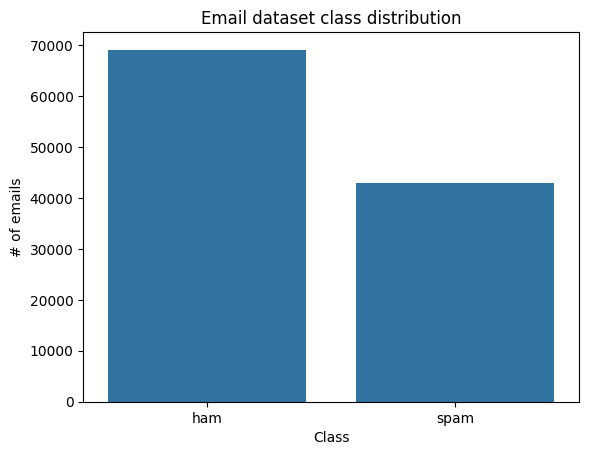

In [3]:
# Class distribution by bar plot
sns.countplot(x = "label", data = df)
plt.title("Email dataset class distribution")
plt.xlabel("Class")
plt.ylabel("# of emails")
plt.show()

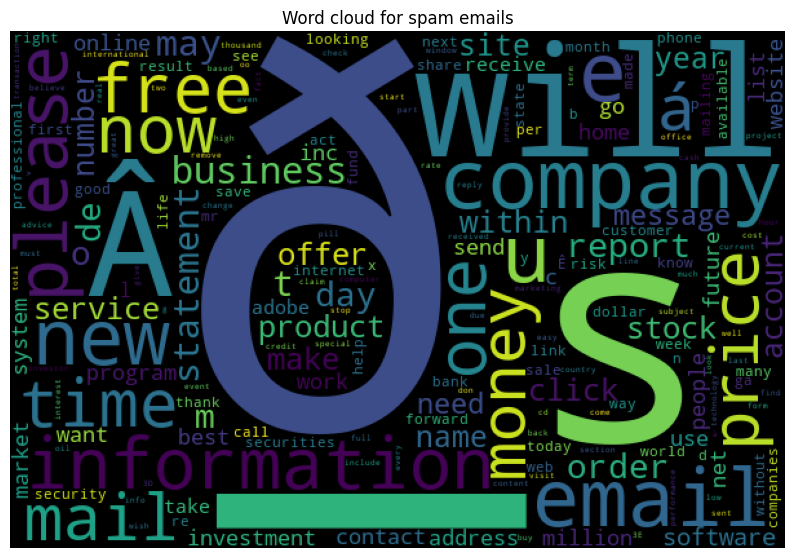

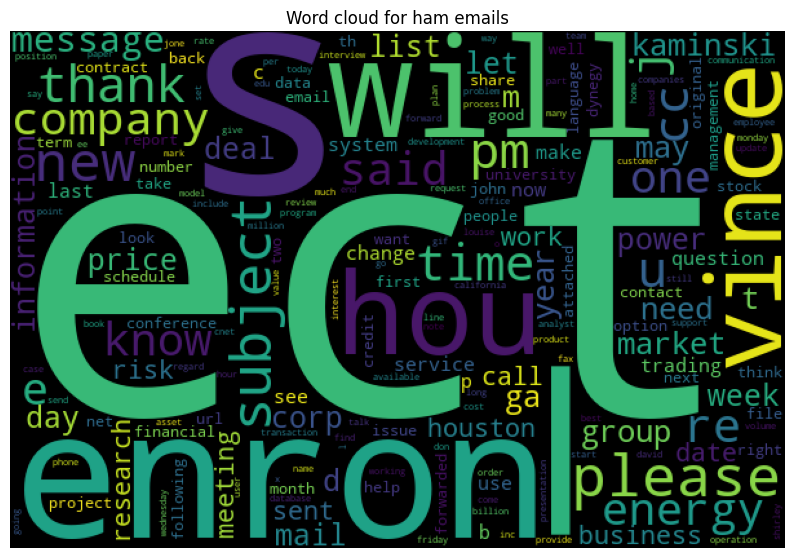

In [4]:
from wordcloud import WordCloud

# Word cloud for spam emails
spamWordsUnique = " ".join(df[df["label"] == "spam"]["text"])
spamWordCloud = WordCloud(width = 600, height = 400, collocations = False).generate(spamWordsUnique)
plt.figure(figsize = (10, 8))
plt.imshow(spamWordCloud)
plt.title("Word cloud for spam emails")
plt.axis("off")
plt.show()

# Word cloud for ham emails
spamWordsUnique = " ".join(df[df["label"] == "ham"]["text"])
hamWordCloud = WordCloud(width = 600, height = 400, collocations = False).generate(spamWordsUnique)
plt.figure(figsize = (10, 8))
plt.imshow(hamWordCloud)
plt.title("Word cloud for ham emails")
plt.axis("off")
plt.show()

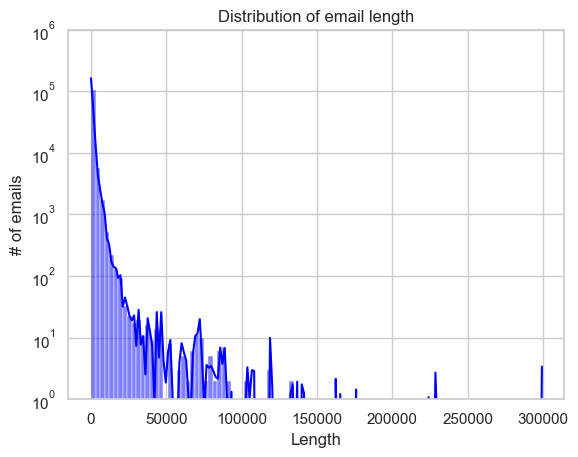

In [5]:
# Set seaborn style and color palette
sns.set(style="whitegrid", palette="pastel")

# Distribution of email length
df["length"] = df["text"].apply(len)
sns.histplot(data=df, x="length", bins=100, kde=True, color="blue")
plt.title("Distribution of email length")
plt.xlabel("Length")
plt.ylabel("# of emails")
plt.yscale("log")       # Logarithmic scale becausae email distribution is skewed a lot
plt.ylim(1, 1e6)
plt.show()

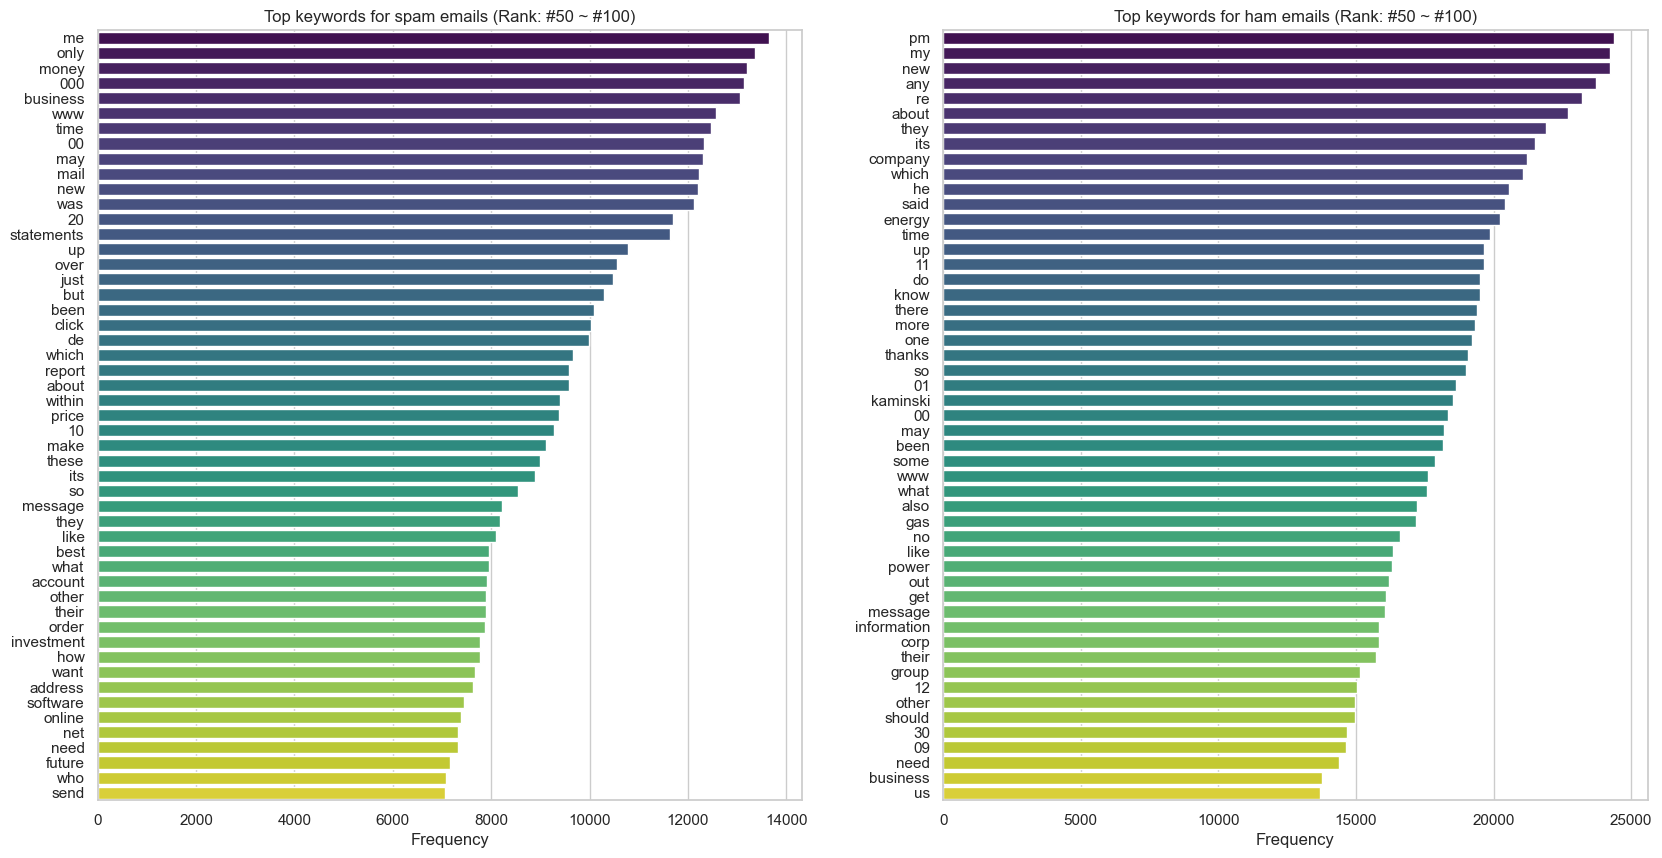

In [6]:
# Top ngram keywords for spam emails
from sklearn.feature_extraction.text import CountVectorizer

def getTopNGrams(text: pd.Series, n: int,  start: int, end: int):
    vec = CountVectorizer(ngram_range=(n, n)).fit(text)
    bagOfWords = vec.transform(text)
    sumOfWords = bagOfWords.sum(axis=0)
    wordsFrequency = [(word, sumOfWords[0, idx]) for word, idx in vec.vocabulary_.items()]
    wordsFrequency = sorted(wordsFrequency, key=lambda x: x[1], reverse=True)
    return wordsFrequency[start-1:end]

ngramCount = 1
rankSearchLimitStart = 50
rankSearchLimitEnd = 100

# spam emails
topNgrams = getTopNGrams(df[df["label"] == "spam"]["text"], ngramCount, rankSearchLimitStart, rankSearchLimitEnd)
topNgrams = dict(topNgrams)

# ham emails
topNgrams_ham = getTopNGrams(df[df["label"] == "ham"]["text"], ngramCount, rankSearchLimitStart, rankSearchLimitEnd)
topNgrams_ham = dict(topNgrams_ham)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

sns.barplot(x=list(topNgrams.values()), y=list(topNgrams.keys()), hue=list(topNgrams.keys()), palette="viridis", legend=False, ax=ax1)
ax1.set_title(f"Top keywords for spam emails (Rank: #{rankSearchLimitStart} ~ #{rankSearchLimitEnd})")
ax1.set_xlabel("Frequency")

sns.barplot(x=list(topNgrams_ham.values()), y=list(topNgrams_ham.keys()), hue=list(topNgrams_ham.keys()), palette="viridis", legend=False, ax=ax2)
ax2.set_title(f"Top keywords for ham emails (Rank: #{rankSearchLimitStart} ~ #{rankSearchLimitEnd})")
ax2.set_xlabel("Frequency")

plt.show()

In [7]:
# Extract the top 10 most frequent words for spam and ham emails
topWords = getTopNGrams(df["text"], 1, 1, 10)
topWords = dict(topWords)
print(topWords)

{'the': 723175, 'to': 533033, 'and': 393928, 'of': 374821, 'in': 266456, 'you': 220187, 'for': 214402, 'is': 186728, 'on': 155102, 'this': 153889}


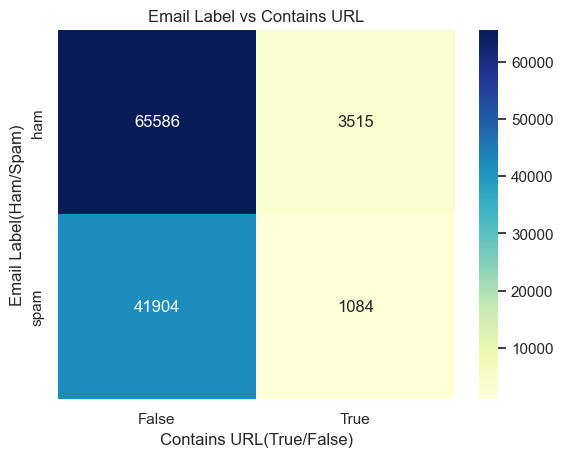

In [8]:
# URL detection for ham/spam emails and their distribution
import re

def detectURL(text:str) -> bool:
    # Regular expression to detect URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return bool(url_pattern.search(text))

df['contains_url'] = df['text'].apply(detectURL)

# Create a cross-tabulation of labels and URL existence
crosstab = pd.crosstab(df['label'], df['contains_url'])

# Create the heatmap
sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlGnBu')

# Set the axis labels and title
plt.xlabel("Contains URL(True/False)")
plt.ylabel("Email Label(Ham/Spam)")
plt.title("Email Label vs Contains URL")

# Show the plot
plt.show()

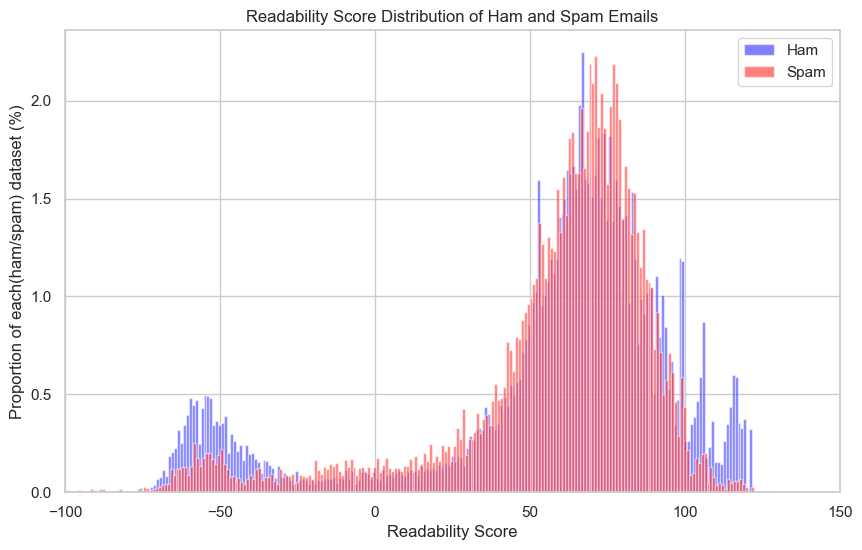

In [14]:
# Readability score is a measure of how easy a piece of text is to read and understand. 
# It is calculated based on the average number of syllables per word and the average number of words per sentence. 
# This diagram shows the distribution of readability scores for ham and spam emails.
import pandas as pd
import matplotlib.pyplot as plt
import textstat

# Sample DataFrame
data = {
    "text": df["text"],
    "label": df["label"]
}

df = pd.DataFrame(data)

# Function to calculate readability score for each email text
def calculate_readability(text):
    return textstat.flesch_reading_ease(text)

# Apply readability score calculation to the DataFrame
df["readability_score"] = df["text"].apply(calculate_readability)

ham_emails = df[df["label"] == "ham"]
spam_emails = df[df["label"] == "spam"]

# Calculate relative frequency for readability score distribution of ham emails
ham_histogram, bins = np.histogram(ham_emails["readability_score"], bins=3000)
total_ham_emails = len(ham_emails)
ham_histogram_percentage = (ham_histogram / total_ham_emails) * 100

# Calculate relative frequency for readability score distribution of spam emails
spam_histogram, _ = np.histogram(spam_emails["readability_score"], bins=bins)
total_spam_emails = len(spam_emails)
spam_histogram_percentage = (spam_histogram / total_spam_emails) * 100

# Plot histograms for readability score distribution of ham and spam emails
plt.figure(figsize=(10, 6))
plt.bar(bins[:-1], ham_histogram_percentage, width=(bins[1]-bins[0]), alpha=0.5, color="blue", label="Ham")
plt.bar(bins[:-1], spam_histogram_percentage, width=(bins[1]-bins[0]), alpha=0.5, color="red", label="Spam", align='edge')
plt.title("Readability Score Distribution of Ham and Spam Emails")
plt.xlabel("Readability Score")
plt.xlim(-100, 150)
plt.ylabel("Proportion of each(ham/spam) dataset (%)")
plt.legend()
plt.grid(True)
plt.show()

# As a result, there was no significant difference in readability score between ham and spam emails.
# However, ham emails have a higher proportion of emails with a extremely low and high readability score compared to spam emails.
# (Almost 2 ~ 3 times)


<>:51: SyntaxWarning: invalid escape sequence '\]'
<>:51: SyntaxWarning: invalid escape sequence '\]'
C:\Users\3NR1QUE\AppData\Local\Temp\ipykernel_44344\2526958352.py:51: SyntaxWarning: invalid escape sequence '\]'
  caption_text = "Punctuation and special characters are defined by string.punctuation in Python,\nCovering !\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ characters."


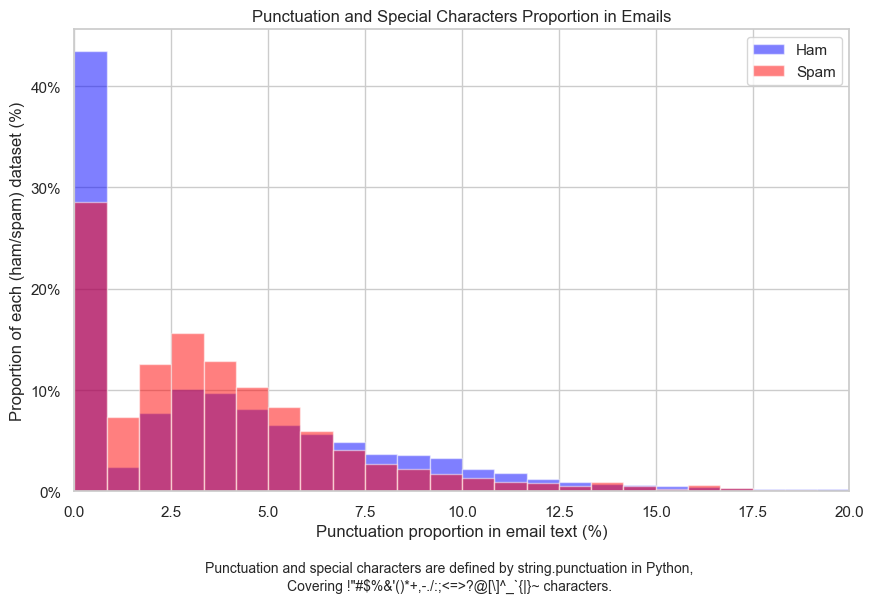

In [51]:
# Punctuation and special characters are often used in spam emails to grab the reader's attention.
# But is it possible to distinguish between ham and spam emails based on the proportion of punctuation and special characters?
# Special characters are "!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~", defined by string.punctuation in Python.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
from matplotlib.ticker import FuncFormatter

# Sample DataFrame
data = {
    "text": df["text"], 
    "label": df["label"]
}
df = pd.DataFrame(data)

# Function to calculate proportion of punctuation and special characters per 100 characters
def calculate_punctuation_proportion(text):
    punctuation_count = sum(1 for char in text if char in string.punctuation)
    total_characters = len(text)
    return (punctuation_count / total_characters) * 100 if total_characters > 0 else 0

# Apply punctuation proportion calculation to the DataFrame
df["punctuation_proportion"] = df["text"].apply(calculate_punctuation_proportion)

# Separate ham and spam emails
ham_emails = df[df["label"] == "ham"]
spam_emails = df[df["label"] == "spam"]

# Plot histograms for punctuation proportion distribution of ham and spam emails
plt.figure(figsize=(10, 6))

# Calculate relative frequency
bins = 120

# Plot histogram for ham emails
plt.hist(ham_emails["punctuation_proportion"], bins=bins, alpha=0.5, color="blue", label="Ham", density=True)
plt.hist(spam_emails["punctuation_proportion"], bins=bins, alpha=0.5, color="red", label="Spam", density=True)

plt.title("Punctuation and Special Characters Proportion in Emails")
plt.xlabel("Punctuation proportion in email text (%)")
plt.xlim(0, 20)
plt.ylabel("Proportion of each (ham/spam) dataset (%)")
plt.legend()
plt.grid(True)

# Function to format y-axis as percentage like 10% from fractional values like 0.1
formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y))
plt.gca().yaxis.set_major_formatter(formatter)

caption_text = "Punctuation and special characters are defined by string.punctuation in Python,\nCovering !\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ characters."
plt.figtext(0.5, -0.05, caption_text, wrap=True, horizontalalignment='center', fontsize=10)

plt.show()

# As a result, spam emails tend to have a higher proportion of punctuation and special characters compared to ham emails.
# It means spam email texts are more likely to contain punctuation and special characters than ham email texts.


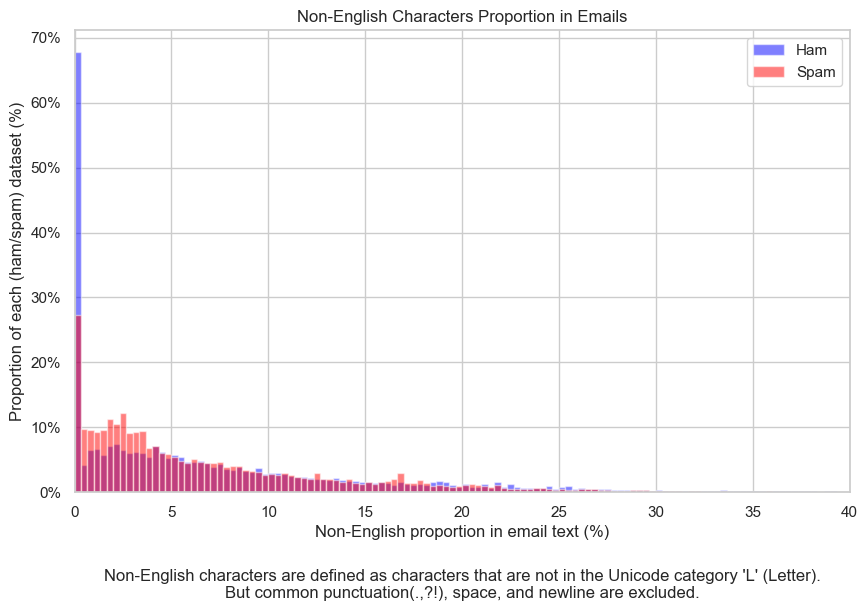

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import unicodedata

data = {
    "text": df["text"],
    "label": df["label"]
}
df = pd.DataFrame(data)

# Function to calculate proportion of non-English characters per 100 characters
def calculate_non_english_proportion(text):
    # Remove whitespaces and newlines
    text = text.replace(" ", "")
    text = text.replace("\n", "")
    text = text.replace(".", "").replace(",", "").replace("!", "").replace("?", "")     # Exclude common punctuation
    non_english_count = sum(1 for char in text if unicodedata.category(char)[0] != 'L')
    total_characters = len(text)
    return (non_english_count / total_characters) * 100 if total_characters > 0 else 0

# Apply non-English proportion calculation to the DataFrame
df["non_english_proportion"] = df["text"].apply(calculate_non_english_proportion)

# Separate ham and spam emails
ham_emails = df[df["label"] == "ham"]
spam_emails = df[df["label"] == "spam"]

# Plot histograms for non-English proportion distribution of ham and spam emails
plt.figure(figsize=(10, 6))

# Calculate relative frequency
bins = 300

# Plot histogram for emails
plt.hist(ham_emails["non_english_proportion"], bins=bins, alpha=0.5, color="blue", label="Ham", density=True)
plt.hist(spam_emails["non_english_proportion"], bins=bins, alpha=0.5, color="red", label="Spam", density=True)

plt.title("Non-English Characters Proportion in Emails")
plt.xlabel("Non-English proportion in email text (%)")
plt.xlim(0, 40)
plt.ylabel("Proportion of each (ham/spam) dataset (%)")
plt.legend()
plt.grid(True)
caption_text = "Non-English characters are defined as characters that are not in the Unicode category 'L' (Letter).\nBut common punctuation(.,?!), space, and newline are excluded."
plt.text(0.5, -0.2, caption_text, ha='center', va='center', transform=plt.gca().transAxes)

# Function to format y-axis as percentage like 10% from fractional values like 0.1
formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y))
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

# As expected, spam emails tend to have a higher proportion of non-English characters compared to ham emails.
# Especially, spam emails have a higher proportion of non-English characters than ham emails.